In [1]:
import sys
import pandas as pd
import numpy as np
import os
import operator
import string
import re
import random
import warnings
warnings.filterwarnings('ignore')
import platform
import json, pickle
import networkx as nx

from copy import deepcopy
from math import sqrt
from random import shuffle
from collections import OrderedDict
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.stats import shapiro, probplot, beta, gaussian_kde
from IPython.display import SVG

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import AllChem, rdDepictor, MolFromSmiles, Descriptors, rdMolDescriptors, Crippen, QED, EState, Lipinski, MolSurf, Fragments

import deepchem as dc
from deepchem.feat.molecule_featurizers import MolGraphConvFeaturizer
from deepchem.feat import RDKitDescriptors

import torch_geometric
from torch.nn import Dropout, BatchNorm1d
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, GINConv, global_add_pool, global_mean_pool, global_max_pool
from torch.optim.lr_scheduler import ReduceLROnPlateau

import sklearn as sk
from sklearn.utils import check_random_state
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import deepchem as dc
from deepchem.splits.splitters import ScaffoldSplitter

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
# What version of Python do you have?
has_gpu = torch.cuda.is_available()
# has_mps = torch.backends.mps.is_built()
device = "cuda" if has_gpu else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Linux-5.4.0-162-generic-x86_64-with-glibc2.29
PyTorch Version: 2.1.0+cu121

Python 3.8.10 (default, May 26 2023, 14:05:08) 
[GCC 9.4.0]
Pandas 2.0.3
Scikit-Learn 1.3.1
GPU is available
Target device is cuda


In [3]:
CFG = {
    'SEED': 42,
    'TRAIN_BATCH_SIZE' : 16,
    'TEST_BATCH_SIZE' : 16,
    'LR' : 0.0001,
    'LOG_INTERVAL' : 20,
    'NUM_EPOCHS' : 100,
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    check_random_state(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3498 non-null   object 
 1   SMILES                      3498 non-null   object 
 2   MLM                         3498 non-null   float64
 3   HLM                         3498 non-null   float64
 4   AlogP                       3496 non-null   float64
 5   Molecular_Weight            3498 non-null   float64
 6   Num_H_Acceptors             3498 non-null   int64  
 7   Num_H_Donors                3498 non-null   int64  
 8   Num_RotatableBonds          3498 non-null   int64  
 9   LogD                        3498 non-null   float64
 10  Molecular_PolarSurfaceArea  3498 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 300.7+ KB


In [7]:
# train 데이터의 SMILES에 있는 분자 알아보기
unique_atoms = set()
for smiles in train['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        unique_atoms.add(atom.GetSymbol())

print(unique_atoms)

{'N', 'Br', 'C', 'S', 'F', 'Cl', 'I', 'Se', 'O'}


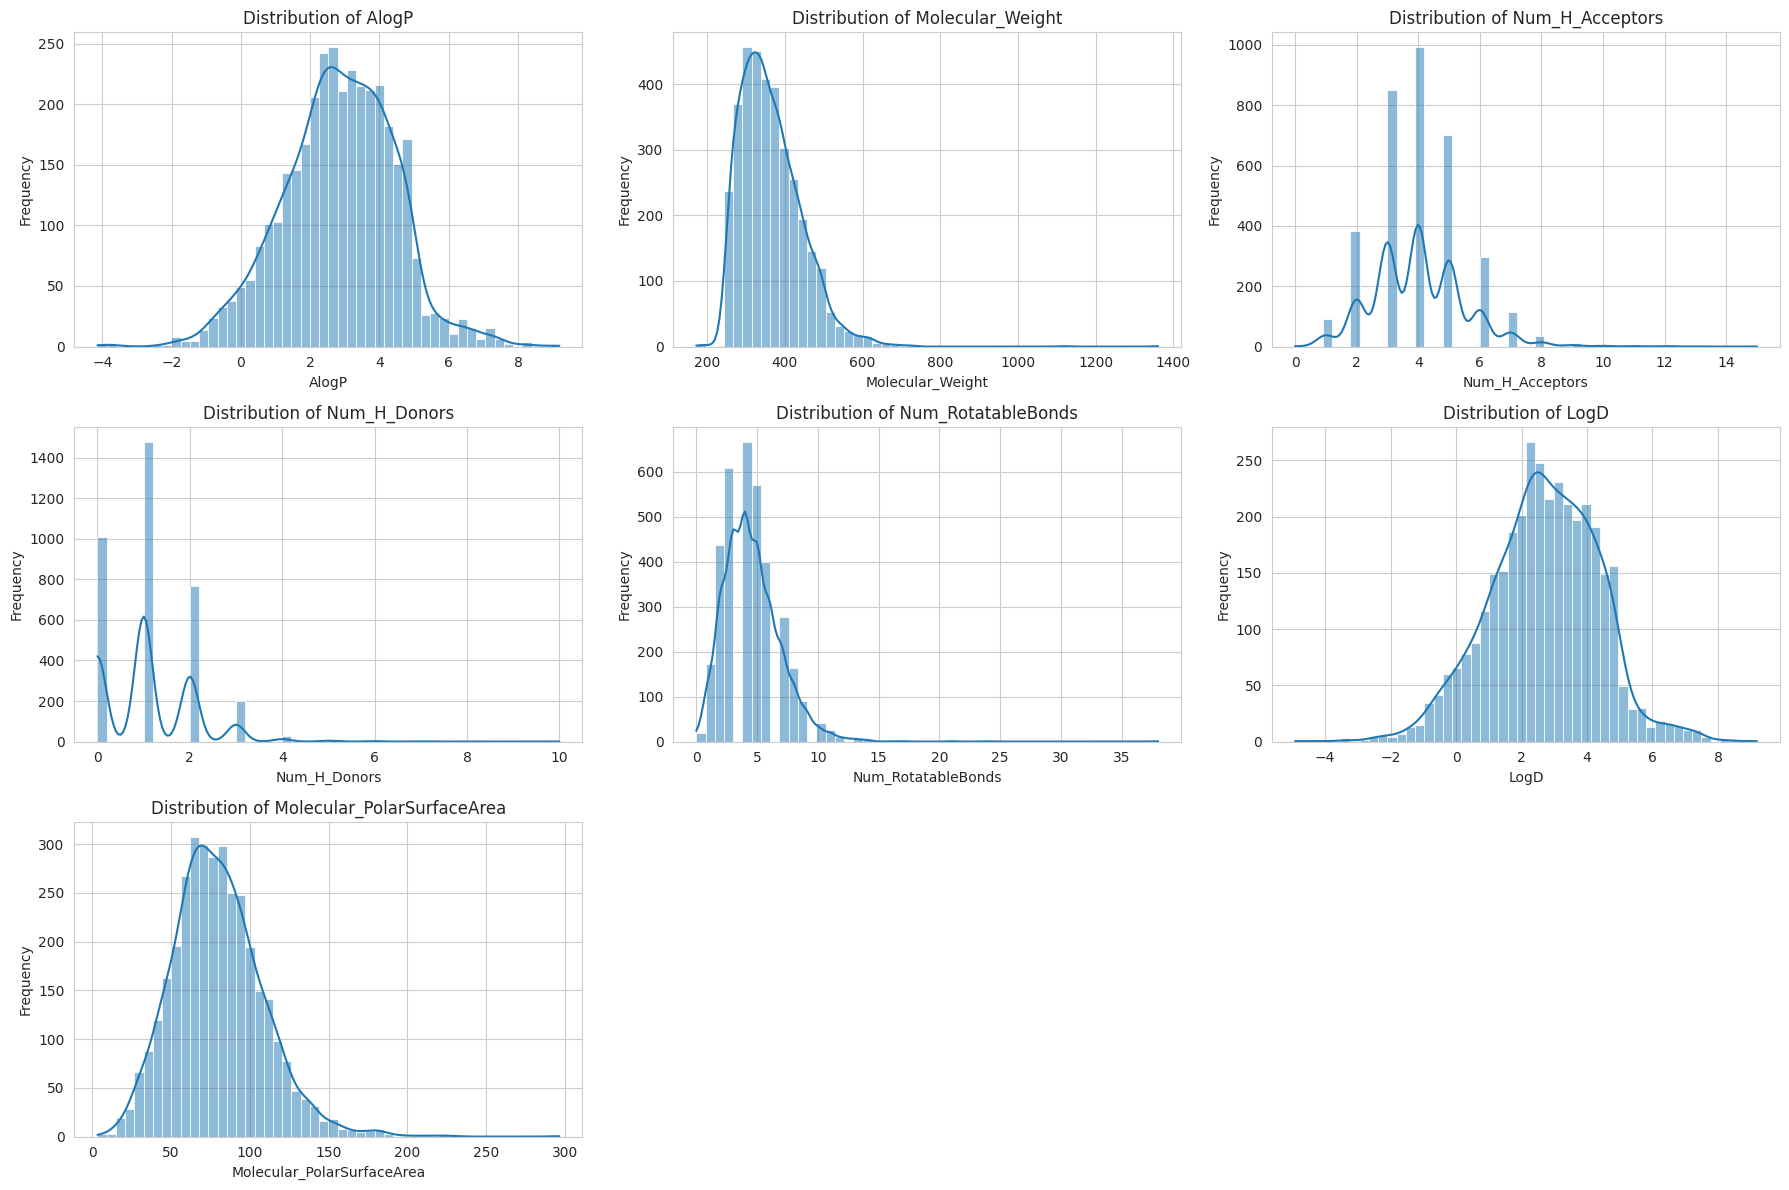

In [8]:
# 타겟, SMILES 제외한 변수들 분포 살펴보기
sns.set_style("whitegrid")
plt.figure(figsize=(18, 12))

features = ["AlogP", "Molecular_Weight", "Num_H_Acceptors", "Num_H_Donors", "Num_RotatableBonds", "LogD", "Molecular_PolarSurfaceArea"]
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

<Figure size 1200x900 with 0 Axes>

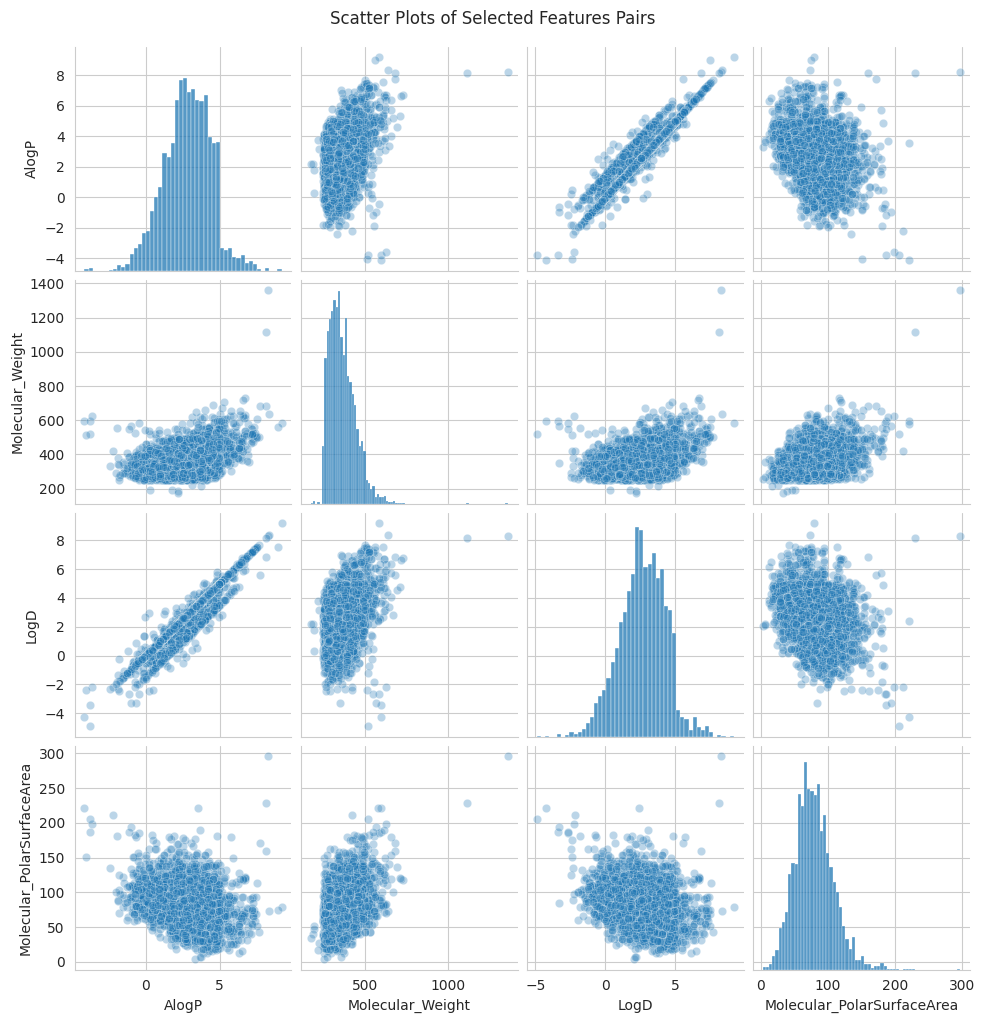

In [9]:
# AlogP와 LogD가 거의 1에 가까운 상관관계를 가짐
selected_features = ['AlogP', 'Molecular_Weight', 'Num_H_Acceptors', 
                    'Num_H_Donors', 'Num_RotatableBonds', 'LogD', 'Molecular_PolarSurfaceArea']

selected_features_with_targets = selected_features + ['MLM', 'HLM']

corr_with_targets = train[selected_features_with_targets].corr()

plt.figure(figsize=(12, 9))
sns.pairplot(data=train, vars=["AlogP", "Molecular_Weight", "LogD", "Molecular_PolarSurfaceArea"], 
            plot_kws={'alpha':0.3})
plt.suptitle('Scatter Plots of Selected Features Pairs', y=1.02)
plt.show()

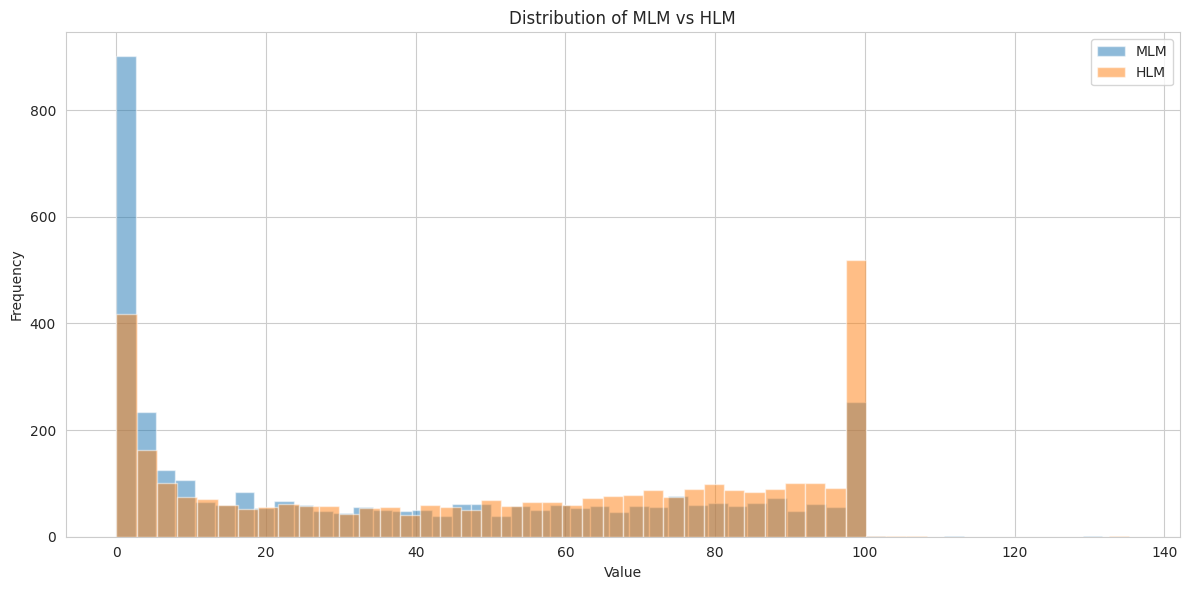

,MLM,HLM
count,3498.000000,3498.000000
mean,37.384742,53.090206
std,35.695993,36.080081
min,0.000000,0.000000
25%,2.433000,15.905500
50%,26.193000,58.023000
75%,70.807250,87.753000
max,131.720000,135.336000


In [10]:
# 타겟변수 살펴보기 -> MLM 평균보다 HLM 평균이 더 크다
desc_stats = train[['MLM', 'HLM']].describe()

plt.figure(figsize=(12, 6))

plt.hist(train['MLM'], bins=50, alpha=0.5, label='MLM')
plt.hist(train['HLM'], bins=50, alpha=0.5, label='HLM')

plt.title('Distribution of MLM vs HLM')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

desc_stats

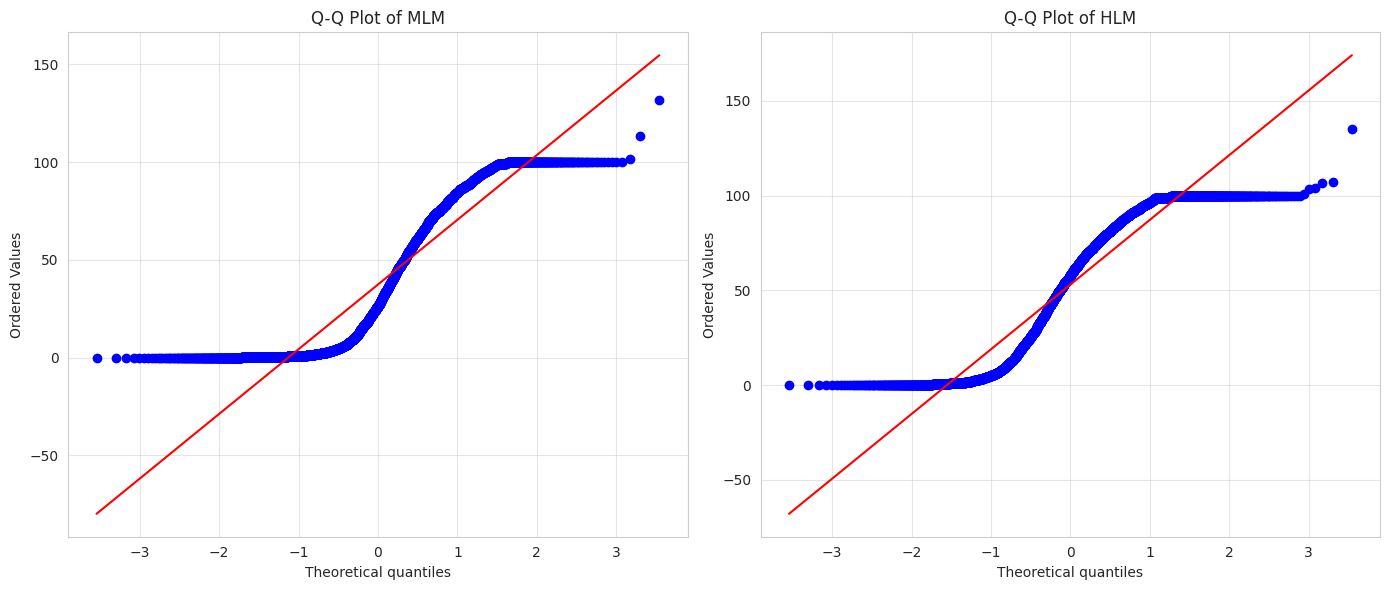

In [11]:
# 타겟 데이터의 분포 살펴보기 -> Gaussianity가 유지되는 구간과 깨지는 구간 살펴보기 -> 다 깨짐...
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
stats.probplot(train['MLM'], dist="norm", plot=plt)
plt.title('Q-Q Plot of MLM')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.subplot(1, 2, 2)
stats.probplot(train['HLM'], dist="norm", plot=plt)
plt.title('Q-Q Plot of HLM')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [12]:
# Shapiro-Wilk test -> p-value가 0.05보다 작으므로, 정규분포를 따른다는 귀무가설을 기각, 정규분포를 따르지 않음
mlm_p_value = shapiro(train['MLM'])[1]
hlm_p_value = shapiro(train['HLM'])[1]
mlm_p_value, hlm_p_value

(0.0, 5.885453550164232e-44)

In [13]:
# SMILES 열의 데이터를 가져와서 각 문자열의 길이 계산
smiles_lengths = train['SMILES'].str.len()

# 최대 및 최소 길이 확인
min_length = smiles_lengths.min()
max_length = smiles_lengths.max()
min_length_idx = smiles_lengths.idxmin()
max_length_idx = smiles_lengths.idxmax()

min_length, min_length_idx, max_length, max_length_idx

(18, 1399, 174, 1172)

In [14]:
train.iloc[1399]

id                                    TRAIN_1399
SMILES                        Brc1cnc2n[se]nc2c1
MLM                                       91.192
HLM                                         99.9
AlogP                                       1.82
Molecular_Weight                         262.953
Num_H_Acceptors                                3
Num_H_Donors                                   0
Num_RotatableBonds                             0
LogD                                        1.82
Molecular_PolarSurfaceArea                 38.67
Name: 1399, dtype: object

In [15]:
train.iloc[1172]

id                                                                   TRAIN_1172
SMILES                        COC(=O)c1cc(F)c(NCCCN(CCCCN(CCCn2c(=O)[nH]c3cc...
MLM                                                                        99.9
HLM                                                                        99.9
AlogP                                                                     8.241
Molecular_Weight                                                       1360.467
Num_H_Acceptors                                                              15
Num_H_Donors                                                                  5
Num_RotatableBonds                                                           38
LogD                                                                      8.257
Molecular_PolarSurfaceArea                                               296.43
Name: 1172, dtype: object

In [16]:
# 원래 SMILES 문자열에는 수소를 명시적으로 표현하지 않지만, 표현하는 경우도 있음(아미노기, 아미드, 방향족 질소 원자에 붙은 수소원자, 일부러 명시적으로 표시 등)
# 그런 부분을 제외하고, 유효하지 않은 화합물이 있는지 확인하기 위한 위한 함수 불러옴 -> 없음.
allowed_atoms = ["I", "O", "F", "Br", "Se", "C", "N", "Cl", "S", "He", "H"]

def contains_only_allowed_atoms(smiles):
    for atom in allowed_atoms:
        smiles = smiles.replace(atom, "")
    return all(char.islower() or char in ['.', '-', '=', '#', '$', '(', ')', '+', '--', '[', ']', '@', '%', ':', '/', '\\', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] for char in smiles)


invalid_smiles = train[~train['SMILES'].apply(contains_only_allowed_atoms)]

invalid_smiles_count = len(invalid_smiles)
invalid_smiles_examples = invalid_smiles.head()

invalid_smiles_count, invalid_smiles_examples[['id', 'SMILES']]

(0,
 Empty DataFrame
 Columns: [id, SMILES]
 Index: [])

In [17]:
# MLM, HLM이 100이 넘는 값에 대한 주최측의 답변
'''
논리적으로는 아무리 안정한 물질이라도 100%를 넘는 값은 나올 수 없는 수치입니다.
그러나 간혹 용해도가 극히 좋지 않으면서 대사안정성이 높은 물질의 경우,
37도에서 30분간 반응하며 주어진 시간동안 실험 전보다 용해도가 더 증가하여 
반응 후 % remaining값이 반응 전 대비 더 큰 값으로 계산되는 경우도 발생될 수 있습니다.
모든 실험값들은 본 상황과 같은 문제를 포함하여 편차가 있을 수 있는 다양한 가능성이 있으므로 실측값들을 그대로 게시하였습니다.

-> 용해도가 안좋다 -> 약 흡수가 잘 안된다...
'''
train[(train['MLM'] >= 100) | (train['HLM'] >= 100)]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
662,TRAIN_0662,O=C(Nc1ccccc1)C1CCCN1C1=NS(=O)(=O)c2ccccc21,131.720,99.570,1.412,355.411,4,1,3,1.412,87.22
1092,TRAIN_1092,COc1c(NC(=O)c2ccc[nH]2)cc(Cl)cc1C(=O)N(C)C,3.820,106.510,2.061,321.759,3,2,4,2.061,74.43
1584,TRAIN_1584,CN(C)S(=O)(=O)CCNCc1ccc(-c2ccccc2)cc1,1.745,135.336,2.075,318.434,3,1,7,2.052,57.79
2159,TRAIN_2159,N#Cc1nccnc1OC1CCN(C(=O)N2CCNC2=O)C1,113.210,99.000,-0.533,302.289,6,1,2,-0.533,111.44
2410,TRAIN_2410,CC(C)CCC1CCN(C(=O)C2CC(O)CN2)CC1,86.878,107.323,1.345,268.395,3,2,4,0.139,52.57
2586,TRAIN_2586,Cc1nc(-c2c[nH]c(C(=O)N3CCOc4cc(F)ccc43)c2)cs1,98.550,103.720,2.876,343.375,3,1,2,3.032,86.46
2948,TRAIN_2948,CCCC(=O)Nc1cc(C(=O)NC2CCCCC2)ccc1S(=O)(=O)c1cc...,101.380,52.330,4.906,462.989,4,2,7,4.906,100.72
3157,TRAIN_3157,CN1C(=O)c2cccc3c2C1=Cc1ccc2ccccc2c1O3,52.847,103.907,3.319,299.323,2,0,0,3.319,29.54
3403,TRAIN_3403,c1cnc2c(C3NCCc4c3[nH]c3ccccc43)cccc2c1,8.890,100.830,3.719,299.369,2,2,1,3.719,40.71


In [18]:
# 100이 넘는 MLM과 HLM 값을 100으로 제한
train['MLM'] = train['MLM'].apply(lambda x: min(x, 100))
train['HLM'] = train['HLM'].apply(lambda x: min(x, 100))

In [19]:
# 중복값에 대한 주최측의 답변

'''
본 데이터는 생물학적 재료를 활용한 실험으로써,
동일 실험 조건이라도 실험 결과는 대사효소의 활성 정도나 반응 시간의 미세한 차이 등 여러가지 요인들에 편차가 발생합니다.
데이터의 신뢰성 확보를 위해, 제공된 대사안정성 데이터 값은 각각 n수를 3으로 하여 평균을 냈으며
MLM에서는 5% 이내, HLM에서는 10% 이내의 값이 나오는지 확인하였으므로, 편차는 제공하지 않습니다.
몇몇 데이터는 실험적 오차가 발생한 것으로 예측됩니다.
중복 값은 배치가 다른 실험에 대한 값입니다.
각 배치마다 reference 물질을 사용하여 확인하였으므로 실험계 전체의 오류는 없으나 batch 중 한 실험은 오류가 있는 것으로 예측되고, 
그와 같은 데이터가 포함될 가능성은 항상 있으므로 그러한 데이터의 처리가 중요하여 경진대회에 포함하였습니다.
'''

duplicate_smiles = train['SMILES'].duplicated(keep=False)
duplicates = train[duplicate_smiles].sort_values(by='SMILES')
duplicates

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,TRAIN_0451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,TRAIN_0543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
366,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
2848,TRAIN_2848,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
2096,TRAIN_2096,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85
1666,TRAIN_1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85


In [20]:
# 중복값의 각 편차가 30이 넘으면 둘 다 제거, 아니면 최대값으로(안정적인 값)
indices_to_keep = []
indices_to_drop = []

for i in range(0, len(duplicates), 2):
    row1 = duplicates.iloc[i]
    row2 = duplicates.iloc[i + 1]

    diff_of_MLM = abs(row1['MLM'] - row2['MLM'])
    diff_of_HLM = abs(row1['HLM'] - row2['HLM'])
    
    if diff_of_MLM > 30 or diff_of_HLM > 30:
        indices_to_drop.extend([row1.name, row2.name])
    else:
        max_MLM = max(row1['MLM'], row2['MLM'])
        max_HLM = max(row1['HLM'], row2['HLM'])
        
        duplicates.at[row1.name, 'MLM'] = max_MLM
        duplicates.at[row1.name, 'HLM'] = max_HLM
        
        indices_to_keep.append(row1.name)
        indices_to_drop.append(row2.name)

filtered_duplicates = duplicates.loc[indices_to_keep]

filtered_duplicates

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
859,TRAIN_0859,CCCCC/N=c1\n(C)c(=O)nc2sccn12,2.860,37.769,2.484,252.336,4,0,4,2.474,73.56
2534,TRAIN_2534,CCOC(=O)CC1(NC(=O)N2Cc3c(sc4c3CCCC4)-n3cccc3C2...,5.884,5.540,6.727,537.736,3,1,6,6.727,120.05
1914,TRAIN_1914,COC(=O)C1(CCCN(C)CCc2ccc(OC)c(OC)c2)CCCc2c1ccc...,12.690,17.971,5.374,485.612,7,0,13,3.870,66.46
2256,TRAIN_2256,COc1ccc(C2=NOC(c3ccc(-c4nnn[nH]4)cc3)C2)cc1,72.473,21.930,2.235,321.333,6,1,4,1.806,85.28
1968,TRAIN_1968,COc1ccc(C2=NOC(c3ccsc3)C2)cc1,8.144,11.348,2.868,259.324,3,0,3,2.868,59.06
2081,TRAIN_2081,COc1ccc([C@H]2Oc3cc(OC)cc(OC)c3C[C@H]2O)cc1,0.829,7.530,2.940,316.348,5,1,4,2.940,57.15


In [21]:
train = train.drop(indices_to_drop)

train = pd.concat([train, filtered_duplicates])

train.reset_index(inplace=True, drop=True)

train.head(10)

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
5,TRAIN_0005,COc1c(F)c(F)cc2c(=O)c(C(=O)NCCCN3CCCC3=O)cn(C3...,27.640,66.630,1.335,419.422,4,1,7,1.335,78.95
6,TRAIN_0006,CN(C)c1cccc2c(S(=O)(=O)NC(CC(=O)O)C(=O)O)cccc12,82.107,69.250,1.954,547.707,7,4,9,0.464,144.42
7,TRAIN_0007,C1=Cn2nc(/C=C/c3cccs3)nc2-c2ccccc2O1,2.673,25.121,2.967,293.343,3,0,2,2.967,68.18
8,TRAIN_0008,COc1ccc2nc(C3=CCCN(C)C3)n(C)c2c1,74.519,71.471,-0.946,347.366,7,2,3,-0.723,104.89
9,TRAIN_0009,CCN1CCCC1CNC(=O)C1CCCN(c2ncnc3[nH]cnc23)C1,73.417,76.291,1.259,357.453,5,2,5,-0.373,90.04


In [22]:
# id는 drop, AlogP 결측치는 LogD로 대체
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)
train['AlogP'].fillna(train['LogD'], inplace=True)
test['AlogP'].fillna(test['LogD'], inplace=True)

In [23]:
# SMILES에서 뽑아올 수 있는 요소 중, MLM / HLM과 상관관계 높은 것들.
train['Mol'] = train['SMILES'].apply(Chem.MolFromSmiles)
test['Mol'] = test['SMILES'].apply(Chem.MolFromSmiles)

descriptor_functions = [
    Descriptors.FpDensityMorgan1, Descriptors.FpDensityMorgan2, Descriptors.MaxPartialCharge
]

Estate_functions = [
    EState.EState_VSA.EState_VSA1, EState.EState_VSA.EState_VSA2, EState.EState_VSA.EState_VSA4, EState.EState_VSA.EState_VSA7, 
    EState.EState_VSA.EState_VSA8, EState.EState_VSA.EState_VSA10, EState.EState.MaxEStateIndex, EState.EState.MinEStateIndex,
]

Lipinski_functions = [
    Lipinski.NHOHCount, Lipinski.NOCount, Lipinski.NumAromaticCarbocycles,
    Lipinski.NumAromaticRings, Lipinski.NumHeteroatoms, Lipinski.RingCount,
    Lipinski.NumSaturatedHeterocycles, Lipinski.NumSaturatedRings,
]
Lipinski_function_names = ["NHOHCount", "NOCount", "NumAromaticCarbocycles", "NumAromaticRings", "NumHeteroatoms", "RingCount", "NumSaturatedHeterocycles", "NumSaturatedRings"]

MolSurf_functions = [
    MolSurf.LabuteASA, MolSurf.PEOE_VSA13, MolSurf.PEOE_VSA14, MolSurf.PEOE_VSA2, 
    MolSurf.PEOE_VSA3,  MolSurf.PEOE_VSA6, MolSurf.PEOE_VSA7, MolSurf.SMR_VSA1, 
    MolSurf.SMR_VSA3, MolSurf.SMR_VSA4, MolSurf.SMR_VSA5, MolSurf.SMR_VSA7, 
    MolSurf.SlogP_VSA3, MolSurf.SlogP_VSA5, MolSurf.SlogP_VSA6, MolSurf.TPSA, 
]
MolSurf_function_names = ["LabuteASA", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA6", "PEOE_VSA7", "SMR_VSA1",
                        "SMR_VSA3", "SMR_VSA4", "SMR_VSA5", "SMR_VSA7", "SlogP_VSA3", "SlogP_VSA5", "SlogP_VSA6", "TPSA"]

Fragments_functions = [
    Fragments.fr_Al_COO, Fragments.fr_Al_OH_noTert, Fragments.fr_Ar_COO, Fragments.fr_Ar_N, Fragments.fr_Ar_NH, 
    Fragments.fr_Ar_OH, Fragments.fr_COO, Fragments.fr_C_O, Fragments.fr_NH0, Fragments.fr_amide, 
    Fragments.fr_benzene, Fragments.fr_NH1, Fragments.fr_Ndealkylation2, Fragments.fr_Nhpyrrole, Fragments.fr_ester, 
    Fragments.fr_ether, Fragments.fr_bicyclic, Fragments.fr_ketone, Fragments.fr_para_hydroxylation, Fragments.fr_phenol, 
    Fragments.fr_phenol_noOrthoHbond, Fragments.fr_thiophene,
    ]
Fragments_function_names = ["fr_Al_COO", "Al_OH_noTert", "Ar_COO", "fr_Ar_N", "fr_Ar_NH", "fr_Ar_OH", "fr_COO2", "fr_C_O", "fr_NH0", "fr_amide", "fr_benzene",
                            "fr_NH1", "fr_Ndealkylation2", "fr_Nhpyrrole", "fr_ester", "fr_ether", "fr_bicyclic", "fr_ketone", "fr_para_hydroxylation", 
                            "fr_phenol", "fr_phenol_noOrthoHbond", "fr_thiophene",]

def count_alcohol_substructures(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        alcohol_pattern = Chem.MolFromSmarts('[OX2H]')
        return len(mol.GetSubstructMatches(alcohol_pattern))
    except:
        return None

for func in descriptor_functions:
    train[func.__name__] = train['Mol'].apply(func)
    test[func.__name__] = test['Mol'].apply(func)

for func in Estate_functions:
    train[func.__name__] = train['Mol'].apply(func)
    test[func.__name__] = test['Mol'].apply(func)

for idx, func in enumerate(Lipinski_functions):
    col_name = Lipinski_function_names[idx]
    train[col_name] = train['Mol'].apply(func)
    test[col_name] = test['Mol'].apply(func)

for idx, func in enumerate(MolSurf_functions):
    col_name = MolSurf_function_names[idx]
    train[col_name] = train['Mol'].apply(func)
    test[col_name] = test['Mol'].apply(func)

for idx, func in enumerate(Fragments_functions):
    col_name = Fragments_function_names[idx]
    train[col_name] = train['Mol'].apply(func)
    test[col_name] = test['Mol'].apply(func)
    
train['QED'] = train['Mol'].apply(QED.qed)
test['QED'] = test['Mol'].apply(QED.qed)
train['Alcohol_Count'] = train['SMILES'].apply(count_alcohol_substructures)
test['Alcohol_Count'] = test['SMILES'].apply(count_alcohol_substructures)

train.drop(columns=['Mol'], inplace=True)
test.drop(columns=['Mol'], inplace=True)

train.head()

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,...,fr_ester,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene,QED,Alcohol_Count
0,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,...,0,2,0,0,0,0,0,0,0.598984,0
1,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,...,0,0,1,0,2,0,0,0,0.924896,0
2,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,...,0,0,3,0,0,0,0,0,0.723816,0
3,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,...,0,0,0,0,0,0,0,0,0.535042,0
4,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43,...,0,1,1,0,0,0,0,0,0.798359,0


In [24]:
# 아래 칼럼 결측값 처리
columns_to_fill = ['MaxPartialCharge']
train[columns_to_fill] = train[columns_to_fill].fillna(0)
test[columns_to_fill] = test[columns_to_fill].fillna(0)

missing_after_fill = train[train[columns_to_fill].isnull().any(axis=1)]

missing_after_fill[columns_to_fill]

,MaxPartialCharge


In [25]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

In [26]:
def atom_features(atom, mol): # 52
    features = one_of_k_encoding(atom.GetSymbol(),['N', 'S', 'F', 'Cl', 'Se', 'Br', 'O', 'C', 'I', 'P'])
    features += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    features += one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    features += one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    features.append(atom.GetIsAromatic())
    features += one_of_k_encoding(atom.GetFormalCharge(), [-1, 0, 1])  # 형식 전하
    features += one_of_k_encoding(str(atom.GetHybridization()), ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2'])  # 혼성
    
    return np.array(features)

In [27]:
# Returns : 원자 개수, 원자 특성 행렬, 인접 행렬
def smile_to_graph(smile):
    # SMILES 문자열로부터 분자 그래프 데이터 생성
    mol = Chem.MolFromSmiles(smile)
    
    # mol.GetNumAtoms() : 분자에 소속되어 있는 원자의 개수
    c_size = mol.GetNumAtoms()
    
    features = []

    # 분자에 소속되어 있는 원자들을 순회하면서 원자 특성 정보 수집
    for atom in mol.GetAtoms():
        feature = atom_features(atom, mol)
        # 정규화?
        features.append( feature / sum(feature) )

    edges = []
    # 분자를 이루는 원자들의 연결 구조 정보를 순회하면서 인접 정보 수집
    # 연결 구조 정보 : 시작 원자 index, 끝 원자 index
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])

    # 연결 구조 정보를 통한 방향 그래프 생성(양방향)
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])

    return c_size, features, edge_index

In [28]:
smile_graph = {}
for df in [train, test]:
    smiles = df['SMILES']
    for smile in smiles:
        g = smile_to_graph(smile)
        smile_graph[smile] = g

In [29]:
dataset = dc.data.NumpyDataset(X=np.array(train['SMILES']), ids=train['SMILES'].values)
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset = splitter.train_test_split(dataset, frac_train=0.86, seed=CFG['SEED'])
train_df = train[train['SMILES'].isin(train_dataset.ids)]
valid_df = train[train['SMILES'].isin(valid_dataset.ids)]
train_df

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,...,fr_ester,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene,QED,Alcohol_Count
6,CN(C)c1cccc2c(S(=O)(=O)NC(CC(=O)O)C(=O)O)cccc12,82.107,69.250,1.954,547.707,7,4,9,0.464,144.42,...,0,0,1,0,0,0,0,0,0.670375,2
11,Nc1nc(N2CCN(c3ccccc3Cl)CC2)nc2ccccc12,0.761,4.273,4.157,339.822,2,1,2,4.157,58.28,...,0,0,1,0,2,0,0,0,0.776659,0
12,CC(C)c1ccc(CCCNS(C)(=O)=O)cc1,66.240,63.680,2.719,255.376,2,1,6,2.721,54.55,...,0,0,0,0,0,0,0,0,0.792765,0
26,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@H](O)C2,73.730,99.000,2.021,290.268,6,5,1,2.010,110.38,...,0,1,1,0,0,4,4,0,0.509593,5
27,CC(C)CCN(C)C1CCN(S(=O)(=O)c2ccc(C(C)(C)C)cc2)CC1,3.855,54.218,4.038,380.588,3,0,7,2.478,49.00,...,0,0,0,0,0,0,0,0,0.745408,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,CS(=O)(=O)N1CCN(CCOc2ccc3c(c2)C(c2cc(F)cc(F)c2...,2.904,4.686,3.219,525.567,6,0,7,3.086,88.19,...,0,1,1,1,0,0,0,0,0.470193,0
3470,Cc1cc(=O)[nH]c(SCC(=O)C23CC4CC(CC(C4)C2)C3)c1C#N,14.990,18.130,3.322,342.455,4,1,4,3.322,95.26,...,0,0,0,1,0,0,0,0,0.850822,0
3471,Cc1ccc(-c2cc(-c3nc4c5ccccc5ncn4n3)[nH]n2)c(C)c1,40.150,32.610,4.609,340.381,4,1,2,4.736,71.75,...,0,0,3,0,1,0,0,0,0.528001,0
3472,Cc1ccc(-c2ccc(C(CN3CCCC3)N(C)C(=O)CN3C(=O)COc4...,58.237,71.640,4.282,553.480,5,0,7,4.009,65.98,...,0,1,1,0,0,0,0,0,0.393065,0


In [30]:
class TestbedDataset(Dataset):
    def __init__(self, df, mode='train', transform=None, pre_transform=None, smile_graph=None, scaler=None):
        super(TestbedDataset, self).__init__(root=None, transform=transform, pre_transform=pre_transform)
        self.mode = mode
        self.smile_graph = smile_graph
        self.scaler = scaler
        
        self.xd = df['SMILES'].tolist()

        if self.mode == 'train':
            self.y = df[['MLM', 'HLM']].values.tolist()
        else:  # 'test' mode
            self.y = [None] * len(self.xd)

        if self.mode == 'train':
            exclude_cols = ['SMILES', 'MLM', 'HLM']
            additional_data = df.drop(exclude_cols, axis=1)
        
        else:
            additional_data = df.drop('SMILES', axis=1)

        if self.mode == 'train':
            self.scaler = StandardScaler()
            self.scaled_data = self.scaler.fit_transform(additional_data)
        elif self.mode == 'test' and self.scaler is not None:
            self.scaled_data = self.scaler.transform(additional_data)
        else:
            raise ValueError("Scaler should be provided for test mode.")

    def len(self):
        return len(self.xd)

    def get(self, idx):
        smiles = self.xd[idx]
        labels = self.y[idx]
        additional_features = self.scaled_data[idx]

        c_size, features, edge_index = self.smile_graph[smiles]

        data = Data(x=torch.Tensor(features),
                    edge_index=torch.LongTensor(edge_index).transpose(1, 0))
        
        if labels:
            data.y = torch.FloatTensor([labels])
        data.c_size = torch.LongTensor([c_size])
        data.additional_features = torch.Tensor(additional_features)

        return data

In [31]:
train_dataset = TestbedDataset(df=train_df, mode='train', smile_graph=smile_graph)
val_dataset = TestbedDataset(df=valid_df, mode='train', smile_graph=smile_graph, scaler=train_dataset.scaler)
test_dataset = TestbedDataset(df=test, mode='test', smile_graph=smile_graph, scaler=train_dataset.scaler)

In [32]:
batch = next(iter(train_dataset))
batch

Data(x=[25, 52], edge_index=[2, 52], y=[1, 2], c_size=[1], additional_features=[66])

In [210]:
"""
GCNConv, GraphConv: 가장 간단한 geometric conv
GATConv: Graph Attention Networks(GAT)에서 사용
SAGEConv: 인접노드의 특징집계
GENConv: 그래프 엣지정보 집계
ChebConv: 고도로 비선형적인 convolution
"""
"""
Model Architecture 구성방식
GATConv를 통한 Attention학습진행 각각의 세부사항을 학습.
SAGEConv, GENConv는 그래프의 세부적부분으로 edge와 node에 대해 모델이 학습, 
Attention이 집중 node와 edge에 집중하게함.
이를 ChebConv를 통해 고도의 비선형성을 모델에 도입시킴.

"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.nn import GATConv, GENConv, ChebConv
from torch_geometric.nn.glob import global_max_pool, global_mean_pool

class GAT_GCN_DenseNet_Style(torch.nn.Module):
    def __init__(self, n_output=2, num_features_xd=52, output_dim=128, dropout=0.2, num_additional_features=66):
        super(GAT_GCN_DenseNet_Style, self).__init__()

        dim = 32
        heads = 4  # Number of attention heads

        self.dropout = Dropout(dropout)
        self.mish = nn.Mish()
        self.n_output = n_output

        # 약물 분자 표현을 위한 GAT 및 GCN 층 구성
        self.conv1 = GATConv(num_features_xd, dim, heads=heads, concat=True)
        self.bn1 = BatchNorm1d(dim * heads)
        self.conv2 = GATConv(dim * heads, dim * heads, concat=True)
        self.bn2 = BatchNorm1d(dim * heads)
        
        self.conv3 = GATConv(dim * heads, dim, heads=heads, concat=True)
        self.bn3 = BatchNorm1d(dim * heads)
        self.conv4 = GENConv(dim * heads, dim * heads)
        self.bn4 = BatchNorm1d(dim * heads)
        
        self.conv5 = ChebConv(dim * heads, dim * heads, K=1)        
        self.fc1_xd = Linear(2 * dim * heads, output_dim)

        # Additional Features Fully Connected Layer
        self.fc_additional = Linear(num_additional_features, output_dim)

        # Concatenation
        self.fc1 = Linear(2 * output_dim, 1024)
        self.fc2 = Linear(1024, 256)
        self.out = Linear(256, self.n_output)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        additional_features = data.additional_features.view(-1, 66)

        # Molecular features
        x1 = F.mish(self.conv1(x, edge_index))
        x1 = self.bn1(x1)
        x2 = F.mish(self.conv2(x1, edge_index) + x1)  # Residual connection
        x2 = self.bn2(x2)
        x3 = F.mish(self.conv3(x2, edge_index) + x1 + x2)  # Residual connection
        x3 = self.bn3(x3)
        x4 = F.mish(self.conv4(x3, edge_index) + x1 + x2 + x3)  # Residual connection
        x4 = self.bn4(x4)
        x5 = F.mish(self.conv5(x4, edge_index) + x1 + x2 + x3 + x4)  # Residual connection
        
        x = torch.cat([global_max_pool(x5, batch), global_mean_pool(x5, batch)], dim=1)
        x = F.mish(self.fc1_xd(x))
        x = self.dropout(x)

        # Process additional features
        additional_out = self.fc_additional(additional_features)
        additional_out = F.mish(additional_out)
        additional_out = self.dropout(additional_out)

        # Concatenation
        xc = torch.cat((x, additional_out), 1)
        xc = self.fc1(xc)
        xc = self.mish(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.mish(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out


In [211]:
def custom_loss(y_pred, y_true):
    loss1 = nn.mse_loss(y_pred[:, 0].flatten(), y_true[:, 0].flatten())
    loss2 = nn.mse_loss(y_pred[:, 1].flatten(), y_true[:, 1].flatten())
    return (loss1**0.5 + loss2**0.5) / 2

In [212]:
def training(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss1 = F.mse_loss(output[:, 0].flatten(), data.y[:, 0].to(device).flatten())
        loss2 = F.mse_loss(output[:, 1].flatten(), data.y[:, 1].to(device).flatten())
        loss = (loss1**0.5 + loss2**0.5) / 2

        loss.backward()
        optimizer.step()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * train_loader.batch_size,
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

In [213]:
def predicting(model, device, loader, mode='validation'):
    model.eval()

    total_preds = []

    total_labels = []

    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            total_preds.append(output.cpu().numpy())
            
            if mode != 'test':
                total_labels.append(data.y.cpu().numpy())
    
    if mode == 'test':
        return np.vstack(total_preds)
    else:
        return np.vstack(total_labels), np.vstack(total_preds)

In [214]:
TRAIN_BATCH_SIZE = CFG['TRAIN_BATCH_SIZE']
TEST_BATCH_SIZE = CFG['TEST_BATCH_SIZE']
LR = CFG['LR']
LOG_INTERVAL = CFG['LOG_INTERVAL']
NUM_EPOCHS = CFG['NUM_EPOCHS']

In [215]:
def rmse(y,f):
    rmse = np.sqrt(((y - f)**2).mean(axis=0))
    return rmse

In [216]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE)

model = GAT_GCN_DenseNet_Style().to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr=0.01)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

model_file_name = './GAT_GCN_Net_best.model'
best_rmse = float('inf')  # 초기의 최고 RMSE 값을 무한대로 설정

for epoch in range(NUM_EPOCHS):
    training(model, device, train_loader, optimizer, epoch+1)
    G, P = predicting(model, device, val_loader)
    ret = rmse(G,P)
    ret_avg = np.mean(ret)
    
    scheduler.step(ret_avg)
    
    if ret_avg < best_rmse:
        best_rmse = ret_avg
        torch.save(model.state_dict(), model_file_name)
        print('Epoch {}: rmse improved to {:.4f}. Model saved!'.format(epoch, best_rmse))
    else:
        print('Epoch {}: rmse {:.4f}. No improvement from {:.4f}.'.format(epoch, ret_avg, best_rmse))

model.load_state_dict(torch.load(model_file_name))

# Epoch 99: rmse 30.9372. No improvement from 30.7190. (baseline)
# Epoch 99: rmse 31.1802. No improvement from 30.8177. (NAdam)
# Epoch 99: rmse 31.4061. No improvement from 30.4840. (ResNet_Adamax)


Training on 2987 samples...
Train epoch: 1 [0/2987 (0%)]	Loss: 45.982735
Train epoch: 1 [320/2987 (11%)]	Loss: 35.671703
Train epoch: 1 [640/2987 (21%)]	Loss: 29.581423
Train epoch: 1 [960/2987 (32%)]	Loss: 30.189617
Train epoch: 1 [1280/2987 (43%)]	Loss: 34.291954
Train epoch: 1 [1600/2987 (53%)]	Loss: 33.791702
Train epoch: 1 [1920/2987 (64%)]	Loss: 36.851963
Train epoch: 1 [2240/2987 (75%)]	Loss: 35.391243
Train epoch: 1 [2560/2987 (86%)]	Loss: 28.196037
Train epoch: 1 [2880/2987 (96%)]	Loss: 31.764729
Make prediction for 487 samples...
Epoch 0: rmse improved to 32.0697. Model saved!
Training on 2987 samples...
Train epoch: 2 [0/2987 (0%)]	Loss: 33.533775
Train epoch: 2 [320/2987 (11%)]	Loss: 35.294815
Train epoch: 2 [640/2987 (21%)]	Loss: 30.824406
Train epoch: 2 [960/2987 (32%)]	Loss: 39.375343
Train epoch: 2 [1280/2987 (43%)]	Loss: 26.758102
Train epoch: 2 [1600/2987 (53%)]	Loss: 36.067768
Train epoch: 2 [1920/2987 (64%)]	Loss: 28.415455
Train epoch: 2 [2240/2987 (75%)]	Loss: 27.

<All keys matched successfully>

In [217]:
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE)

In [218]:
preds = predicting(model, device, test_loader, mode='test')
preds

Make prediction for 483 samples...


array([[2.11126537e+01, 4.29728813e+01],
       [6.29744415e+01, 8.44882278e+01],
       [3.21795921e+01, 4.96361008e+01],
       [6.34951973e+01, 7.93738785e+01],
       [5.77879868e+01, 7.70440598e+01],
       [6.37806053e+01, 8.30305099e+01],
       [3.36971817e+01, 5.84373856e+01],
       [4.37155724e+01, 6.37853241e+01],
       [1.46043091e+01, 2.98360462e+01],
       [2.25461521e+01, 4.83920174e+01],
       [4.57783203e+01, 5.90032768e+01],
       [5.89123878e+01, 7.79393768e+01],
       [6.73055496e+01, 8.50635452e+01],
       [4.06302223e+01, 6.37660179e+01],
       [1.95923195e+01, 3.94897079e+01],
       [6.11959000e+01, 7.70702744e+01],
       [3.06794338e+01, 3.56944389e+01],
       [3.35338593e+01, 6.22892113e+01],
       [8.17223358e+01, 8.16704330e+01],
       [4.84963188e+01, 7.12585983e+01],
       [6.00087309e+00, 2.40232639e+01],
       [1.33398552e+01, 2.42744179e+01],
       [2.27024651e+01, 3.31400642e+01],
       [3.13531017e+01, 5.31832199e+01],
       [1.880888

In [219]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission

,id,MLM,HLM
0,TEST_000,0,0
1,TEST_001,0,0
2,TEST_002,0,0
3,TEST_003,0,0
4,TEST_004,0,0
...,...,...,...
478,TEST_478,0,0
479,TEST_479,0,0
480,TEST_480,0,0
481,TEST_481,0,0


In [220]:
sample_submission['MLM'] = preds[:, 0]
sample_submission['HLM'] = preds[:, 1]
sample_submission

,id,MLM,HLM
0,TEST_000,21.112654,42.972881
1,TEST_001,62.974442,84.488228
2,TEST_002,32.179592,49.636101
3,TEST_003,63.495197,79.373878
4,TEST_004,57.787987,77.044060
...,...,...,...
478,TEST_478,3.045275,11.737504
479,TEST_479,74.670967,86.065231
480,TEST_480,29.613056,51.689617
481,TEST_481,60.973404,80.257675


In [221]:
sample_submission.to_csv('./GAT_GCN_submission.csv', index=False)